In [9]:
from mdgp.experiments.uci.data.datasets import Energy

In [16]:
import torch
from torch import Tensor
from scipy.cluster.vq import kmeans2, ClusterError
from mdgp.experiments.uci.data.datasets import UCIDataset


torch.set_default_dtype(torch.float64)


def empty_cluster_safe_kmeans(x: Tensor, k: int, num_retries: int = 1000) -> Tensor:
    """
    Initialize inducing points using kmeans. (from paper)
    """
    for _ in range(num_retries):
        try:
            return torch.from_numpy(kmeans2(x, k, missing='raise')[0]).to(x.device, x.dtype)
        except ClusterError:
            continue 
    
    return torch.from_numpy(kmeans2(x, k, missing='warn')[0]).to(x.device, x.dtype)


def get_inducing_points(dataset: UCIDataset, num_inducing_points: int) -> Tensor:
    """
    Initialize inducing points using kmeans. (from paper)
    """
    return empty_cluster_safe_kmeans(dataset.train_x, num_inducing_points)

In [21]:
Energy().download_data()

In [22]:
get_inducing_points(Energy(), 210).shape

/tmp/ipykernel_544532/1380870268.py:20: UserWarning: One of the clusters is empty. Re-run kmeans with a different initialization.
  return torch.from_numpy(kmeans2(x, k, missing='warn')[0]).to(x.device, x.dtype)


torch.Size([210, 8])

In [10]:
Energy()

In [4]:
from mdgp.variational.spherical_harmonic_features.utils import total_num_harmonics

In [7]:
total_num_harmonics(3, 13)

119

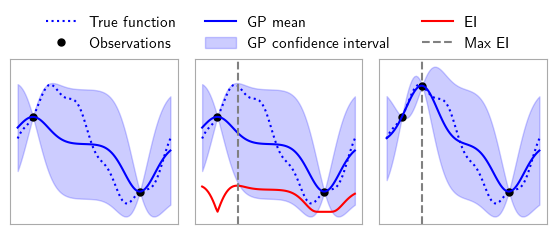

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF

def bayesian_optimization_example():
    # Define the true function
    def true_function(x):
        return np.sin(2 * np.pi * x) + 0.1 * np.cos(10 * np.pi * x)

    # Generate initial observations
    x_init = np.array([[0.1], [0.8]])
    y_init = true_function(x_init)

    # Create a Gaussian Process Regressor
    kernel = RBF(length_scale=0.1, length_scale_bounds="fixed")
    gp = GaussianProcessRegressor(kernel=kernel)

    # Fit the GP model to the initial observations
    gp.fit(x_init, y_init)

    # Plot the initial GP model
    x_plot = np.linspace(0, 1, 100)[:, np.newaxis]
    y_pred, y_std = gp.predict(x_plot, return_std=True)

    plt.rcParams.update({
        "text.usetex": True,
        "font.family": "sans-serif",
        "font.sans-serif": ["Computer Modern Sans Serif"],
        "font.size": 11,
    })

    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(5.7, 2.15))
    ax1.plot(x_plot, true_function(x_plot), 'b:', label='True function')
    ax1.plot(x_init, y_init, 'k.', markersize=10, label='Observations')
    ax1.plot(x_plot, y_pred, 'b-', label='GP mean')
    ax1.fill_between(x_plot.flatten(), y_pred - 0.98 * y_std, y_pred + 0.98 * y_std, alpha=0.2, color='b', label='GP confidence interval')
    ax1.set_xticks([])
    ax1.set_yticks([])
    ax1.spines['bottom'].set_color('#aaaaaa')
    ax1.spines['top'].set_color('#aaaaaa') 
    ax1.spines['right'].set_color('#aaaaaa')
    ax1.spines['left'].set_color('#aaaaaa')

    # Calculate the expected improvement acquisition function
    xi = 0.01
    y_max = np.max(y_init)
    ei = (y_pred - y_max - xi) * norm.cdf((y_pred - y_max - xi) / y_std) + y_std * norm.pdf((y_pred - y_max - xi) / y_std)
    ei[y_std == 0] = 0

    # Plot the GP model and the acquisition function
    ax2.plot(x_plot, true_function(x_plot), 'b:')
    ax2.plot(x_init, y_init, 'k.', markersize=10)
    ax2.plot(x_plot, y_pred, 'b-')
    ax2.fill_between(x_plot.flatten(), y_pred - 0.98 * y_std, y_pred + 0.98 * y_std, alpha=0.2, color='b')
    ax2.plot(x_plot, 2 * ei - ax2.get_ylim()[1], 'r-', label='EI')
    ax2.set_xticks([])
    ax2.set_yticks([])
    ax2.spines['bottom'].set_color('#aaaaaa')
    ax2.spines['top'].set_color('#aaaaaa') 
    ax2.spines['right'].set_color('#aaaaaa')
    ax2.spines['left'].set_color('#aaaaaa')

    # Find the point with the highest expected improvement
    x_next = x_plot[np.argmax(ei)]
    ax2.axvline(x_next, linestyle='--', color='gray', label='Max EI')
    y_next = true_function(x_next)

    # Add the new observation to the data
    x_new = np.vstack((x_init, x_next))
    y_new = np.append(y_init, y_next)

    # Fit the GP model to the updated observations
    gp.fit(x_new, y_new)

    # Plot the updated GP model
    y_pred, y_std = gp.predict(x_plot, return_std=True)
    ax3.axvline(x_next, linestyle='--', color='gray', label='Max EI')
    ax3.plot(x_plot, true_function(x_plot), 'b:')
    ax3.plot(x_new, y_new, 'k.', markersize=10)
    ax3.plot(x_plot, y_pred, 'b-')
    ax3.fill_between(x_plot.flatten(), y_pred - 0.98 * y_std, y_pred + 0.98 * y_std, alpha=0.2, color='b')
    ax3.set_xticks([])
    ax3.set_yticks([])
    ax3.spines['bottom'].set_color('#aaaaaa')
    ax3.spines['top'].set_color('#aaaaaa') 
    ax3.spines['right'].set_color('#aaaaaa')
    ax3.spines['left'].set_color('#aaaaaa')

    # Set the same y-axis range for all subplots
    y_min = min(ax1.get_ylim()[0], ax2.get_ylim()[0], ax3.get_ylim()[0])
    y_max = max(ax1.get_ylim()[1], ax2.get_ylim()[1], ax3.get_ylim()[1])
    for ax in [ax1, ax2, ax3]:
        ax.set_ylim(y_min, y_max)

    # Add a single legend without duplicates
    lines, labels = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    lines.extend(lines2[-2:])
    labels.extend(labels2[-2:])
    legend = fig.legend(lines, labels, loc='upper center', 
               ncol=len(labels) // 2, bbox_to_anchor=(0.5, 1.14), edgecolor='white')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.savefig('./plots/bayesian_optimization_schematic.pdf', dpi=300, bbox_extra_artists=(legend,), bbox_inches='tight')
    plt.show()

# Call the function to run the example
bayesian_optimization_example()

/home/kacperwyrwal/miniconda3/envs/mdgp_uci/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


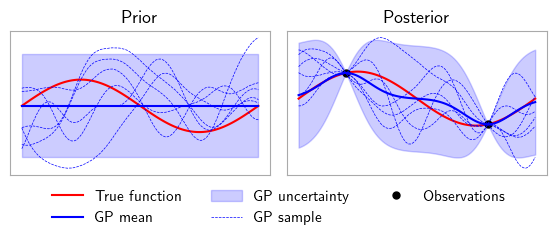

In [59]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel

def gaussian_process_example():
    # Define the true function
    x = np.linspace(0, 1, 100)
    y_true = np.sin(2 * np.pi * x)

    # Generate random observations
    x_obs = np.array([[0.2], [0.8]])
    y_obs = np.sin(2 * np.pi * x_obs)

    # Create a Gaussian Process Regressor
    kernel = RBF(length_scale=0.1, length_scale_bounds="fixed") + WhiteKernel(noise_level=1e-5)
    gp = GaussianProcessRegressor(kernel=kernel)
    num_samples = 6

    plt.rcParams.update({
        "text.usetex": True,
        "font.family": "sans-serif",
        "font.sans-serif": ["Computer Modern Sans Serif"],
        "font.size": 11,
    })

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(5.7, 2.15))

    # Plot the prior GP
    y_mean, y_std = gp.predict(x.reshape(-1, 1), return_std=True)
    ax1.plot(x, y_true, 'r-', label='True function')
    ax1.plot(x, y_mean, 'b-', label='GP mean')
    ax1.fill_between(x, y_mean - 1.96 * y_std, y_mean + 1.96 * y_std, alpha=0.2, color='b', label='GP uncertainty')

    # Plot 5 samples from the prior GP
    for _ in range(num_samples):
        y_sample = gp.sample_y(x.reshape(-1, 1), random_state=None)
        ax1.plot(x, y_sample, 'b--', linewidth=0.5, label='GP sample' if _ == 0 else None)

    ax1.set_title('Prior')
    ax1.set_xticks([])
    ax1.set_yticks([])
    ax1.spines['bottom'].set_color('#aaaaaa')
    ax1.spines['top'].set_color('#aaaaaa') 
    ax1.spines['right'].set_color('#aaaaaa')
    ax1.spines['left'].set_color('#aaaaaa')

    # Fit the GP model to the observations
    gp.fit(x_obs, y_obs)

    # Plot the posterior GP
    y_mean, y_std = gp.predict(x.reshape(-1, 1), return_std=True)
    ax2.plot(x, y_true, 'r-')
    ax2.plot(x_obs, y_obs, 'k.', markersize=10, label='Observations')
    ax2.plot(x, y_mean, 'b-')
    ax2.fill_between(x, y_mean - 1.96 * y_std, y_mean + 1.96 * y_std, alpha=0.2, color='b')

    # Plot 5 samples from the posterior GP
    for _ in range(num_samples):
        y_sample = gp.sample_y(x.reshape(-1, 1), random_state=None)
        ax2.plot(x, y_sample, 'b--', linewidth=0.5, label=None)

    ax2.set_title('Posterior')
    ax2.set_xticks([])
    ax2.set_yticks([])
    ax2.spines['bottom'].set_color('#aaaaaa')
    ax2.spines['top'].set_color('#aaaaaa') 
    ax2.spines['right'].set_color('#aaaaaa')
    ax2.spines['left'].set_color('#aaaaaa')

    # Add a single legend without duplicates
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    lines = lines1 + [line for line in lines2 if line not in lines1]
    labels = labels1 + [label for label, line in zip(labels2, lines2) if line not in lines1]
    legend = fig.legend(lines, labels, loc='upper center', ncol=len(labels) // 2 + 1, bbox_to_anchor=(0.5, 0.10), edgecolor='white')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.savefig('./plots/gaussian_process_schematic.pdf', dpi=300, bbox_extra_artists=(legend,), bbox_inches='tight')
    plt.show()

# Call the function to run the example
gaussian_process_example()

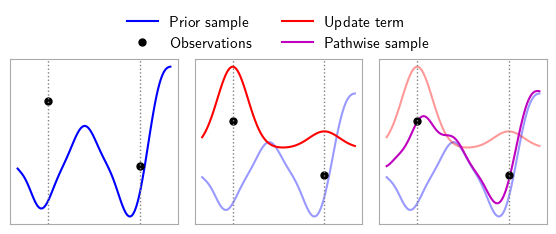

In [69]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF

def pathwise_sampling_example():

    np.random.seed(0)
    # Define the true function (sinusoid)
    x = np.linspace(0, 1, 100)
    y_true = np.sin(2 * np.pi * x)

    # Generate two observations
    x_obs = np.array([[0.2], [0.8]])
    y_obs = np.sin(2 * np.pi * x_obs)

    # Create a Gaussian Process Regressor
    kernel = RBF(length_scale=0.1, length_scale_bounds="fixed")
    gp = GaussianProcessRegressor(kernel=kernel, alpha=1e-10)

    # Sample a function from the GP prior
    y_prior = gp.sample_y(x.reshape(-1, 1), random_state=None).flatten()

    # Calculate the update term using equation 11
    K_x_obs = kernel(x.reshape(-1, 1), x_obs)
    K_obs_obs = kernel(x_obs, x_obs) + 1e-10 * np.eye(len(x_obs))
    update = K_x_obs @ np.linalg.solve(K_obs_obs, y_obs - y_prior[np.searchsorted(x, x_obs)])

    # Calculate the pathwise sample by adding the prior sample and the update term
    y_pathwise = y_prior + update.flatten()

    plt.rcParams.update({
        "text.usetex": True,
        "font.family": "sans-serif",
        "font.sans-serif": ["Computer Modern Sans Serif"],
        "font.size": 11,
    })

    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(5.7, 2.15))

    ax1.plot(x, y_prior, 'b-', label='Prior sample')
    ax1.plot(x_obs, y_obs, 'k.', markersize=10, label='Observations')
    for x_ob, y_ob in zip(x_obs.flatten(), y_obs.flatten()):
        ax1.axvline(x_ob, linestyle=':', color='gray', linewidth=1.0)
    ax1.set_xticks([])
    ax1.set_yticks([])
    ax1.spines['bottom'].set_color('#aaaaaa')
    ax1.spines['top'].set_color('#aaaaaa') 
    ax1.spines['right'].set_color('#aaaaaa')
    ax1.spines['left'].set_color('#aaaaaa')

    alpha = 0.4

    ax2.plot(x, y_prior, 'b-', alpha=alpha)
    ax2.plot(x_obs, y_obs, 'k.', markersize=10)
    for x_ob, y_ob in zip(x_obs.flatten(), y_obs.flatten()):
        ax2.axvline(x_ob, linestyle=':', color='gray', linewidth=1.0)
    ax2.plot(x, update, 'r-', label='Update term')
    ax2.set_xticks([])
    ax2.set_yticks([])
    ax2.spines['bottom'].set_color('#aaaaaa')
    ax2.spines['top'].set_color('#aaaaaa') 
    ax2.spines['right'].set_color('#aaaaaa')
    ax2.spines['left'].set_color('#aaaaaa')

    ax3.plot(x, y_prior, 'b-', alpha=alpha)
    ax3.plot(x, update, 'r-', alpha=alpha)
    ax3.plot(x, y_pathwise, 'm-', label='Pathwise sample')
    ax3.plot(x_obs, y_obs, 'k.', markersize=10)
    for x_ob, y_ob in zip(x_obs.flatten(), y_obs.flatten()):
        ax3.axvline(x_ob, linestyle=':', color='gray', linewidth=1.0)
    ax3.set_xticks([])
    ax3.set_yticks([])
    ax3.spines['bottom'].set_color('#aaaaaa')
    ax3.spines['top'].set_color('#aaaaaa') 
    ax3.spines['right'].set_color('#aaaaaa')
    ax3.spines['left'].set_color('#aaaaaa')

    lines, labels = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    lines3, labels3 = ax3.get_legend_handles_labels()
    lines += [lines2[-1], lines3[-1]]
    labels += [labels2[-1], labels3[-1]]
    legend = fig.legend(lines, labels, loc='upper center', ncol=len(labels) // 2, bbox_to_anchor=(0.5, 1.14), edgecolor='white')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.savefig('./plots/pathwise_sampling_schematic.pdf', dpi=300, bbox_extra_artists=(legend,), bbox_inches='tight')
    plt.show()

pathwise_sampling_example()

In [35]:
import torch 
import gpytorch 


class SimpleDeepGPLayer(gpytorch.models.deep_gps.DeepGPLayer):
    def __init__(self, input_dims=1, output_dims=None, num_inducing=100):
        batch_shape = torch.Size([output_dims]) if output_dims else torch.Size([])

        variational_distribution = gpytorch.variational.CholeskyVariationalDistribution(
            num_inducing_points=num_inducing,
            batch_shape=batch_shape,
        )
        variational_strategy = gpytorch.variational.VariationalStrategy(
            self,
            torch.randn(num_inducing, input_dims),
            variational_distribution,
            learn_inducing_locations=True
        )
        
        super(SimpleDeepGPLayer, self).__init__(variational_strategy, input_dims, output_dims)
        self.mean_module = gpytorch.means.ZeroMean(batch_shape=batch_shape)
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.MaternKernel(nu=1.5, batch_shape=batch_shape), batch_shape=batch_shape)

    def forward(self, inputs):
        mean_x = self.mean_module(inputs)
        covar_x = self.covar_module(inputs)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)


class TwoLayerDGPModel(gpytorch.models.deep_gps.DeepGP):
    def __init__(self):
        super(TwoLayerDGPModel, self).__init__()

        # Define the layers of the deep GP model
        self.hidden_layer = SimpleDeepGPLayer(
            output_dims=3, 
        )
        self.output_layer = SimpleDeepGPLayer(
            input_dims=3,
            output_dims=None, 
        )

        # Set the likelihood
        self.likelihood = gpytorch.likelihoods.GaussianLikelihood()

    def forward(self, inputs):
        h1 = self.hidden_layer(inputs)
        output = self.output_layer(h1)
        return output
    

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

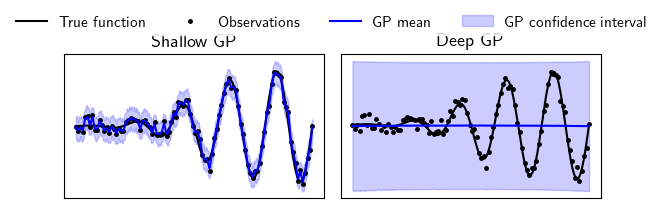

In [37]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import gpytorch
from tqdm.auto import tqdm 


def rapidly_oscillating_function(x):
    freq = 10 * np.pi
    amp = 1 / (1 + np.exp(-10 * (x - 0.5)))
    return amp * np.sin(freq * x)


class ShallowGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y):
        likelihood = gpytorch.likelihoods.GaussianLikelihood()
        super(ShallowGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ZeroMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.MaternKernel(nu=0.5))

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)


def deep_gp_example_gpytorch():
    # Generate training data
    x_train = torch.linspace(0, 1, 100).reshape(-1, 1)
    y_train = rapidly_oscillating_function(x_train.numpy())
    y_train = y_train + np.random.normal(0, 0.1, y_train.shape)
    y_train = torch.from_numpy(y_train).float().ravel()

    # Generate test data
    x_test = torch.linspace(0, 1, 500).reshape(-1, 1)
    y_true = rapidly_oscillating_function(x_test.numpy())
    y_true = torch.from_numpy(y_true).float().ravel()

    # Create shallow GP model
    shallow_gp = ShallowGPModel(x_train, y_train)

    # Optimize shallow GP model
    shallow_gp.train()
    optimizer = torch.optim.Adam([
        {'params': shallow_gp.parameters()},
    ], lr=0.01)
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(shallow_gp.likelihood, shallow_gp)
    for i in (pbar := tqdm(range(1000))):
        optimizer.zero_grad()
        output = shallow_gp(x_train)
        loss = -mll(output, y_train)
        loss.backward()
        optimizer.step()
        pbar.set_postfix({'Loss': loss.item()})

    # Create deep GP model
    deep_gp = TwoLayerDGPModel()

    # Optimize deep GP model
    deep_gp.train()
    deep_optimizer = torch.optim.Adam([
        {'params': deep_gp.parameters()},
    ], lr=0.01)
    deep_mll = gpytorch.mlls.DeepApproximateMLL(gpytorch.mlls.VariationalELBO(deep_gp.likelihood, deep_gp, num_data=y_train.size(0)))
    for i in (pbar := tqdm(range(100))):
        deep_optimizer.zero_grad()
        deep_output = deep_gp(x_train)
        deep_loss = -deep_mll(deep_output, y_train)
        deep_loss.backward()
        deep_optimizer.step()
        pbar.set_postfix({'Loss': deep_loss.item()})

    # Make predictions
    shallow_gp.eval()
    with torch.no_grad(), gpytorch.settings.fast_pred_var():
        shallow_pred = shallow_gp.likelihood(shallow_gp(x_test))
        shallow_mean = shallow_pred.mean
        shallow_var = shallow_pred.variance

    deep_gp.eval()
    with torch.no_grad(), gpytorch.settings.fast_pred_var(), gpytorch.settings.num_likelihood_samples(100):
        deep_pred = deep_gp.likelihood(deep_gp(x_test))
        deep_mean = deep_pred.mean.mean(0)
        deep_var = deep_pred.variance.mean(0)

    plt.rcParams.update({
        "text.usetex": True,
        "font.family": "sans-serif",
        "font.sans-serif": ["Computer Modern Sans Serif"],
        "font.size": 11,
    })

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(5.7, 2.15))

    ax1.plot(x_test, y_true, 'k-', label='True function')
    ax1.plot(x_train, y_train, 'k.', markersize=5, label='Observations')
    ax1.plot(x_test, shallow_mean.numpy(), 'b-', label='GP mean')
    ax1.fill_between(x_test.flatten(), shallow_mean.numpy().flatten() - 1.96 * np.sqrt(shallow_var.numpy().flatten()),
                     shallow_mean.numpy().flatten() + 1.96 * np.sqrt(shallow_var.numpy().flatten()),
                     alpha=0.2, color='b', label='GP confidence interval')
    ax1.set_title('Shallow GP')
    ax1.set_xticks([])
    ax1.set_yticks([])

    ax2.plot(x_test, y_true, 'k-')
    ax2.plot(x_train, y_train, 'k.', markersize=5)
    ax2.plot(x_test, deep_mean.numpy(), 'b-')
    ax2.fill_between(x_test.flatten(), deep_mean.numpy().flatten() - 1.96 * np.sqrt(deep_var.numpy().flatten()),
                     deep_mean.numpy().flatten() + 1.96 * np.sqrt(deep_var.numpy().flatten()),
                     alpha=0.2, color='b')
    ax2.set_title('Deep GP')
    ax2.set_xticks([])
    ax2.set_yticks([])

    lines1, labels1 = ax1.get_legend_handles_labels()
    fig.legend(lines1, labels1, loc='upper center', ncol=len(labels1), bbox_to_anchor=(0.5, 1.02), edgecolor='white')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.savefig('./plots/deep_gp_example_gpytorch.pdf', dpi=300, bbox_inches='tight')
    plt.show()

deep_gp_example_gpytorch()

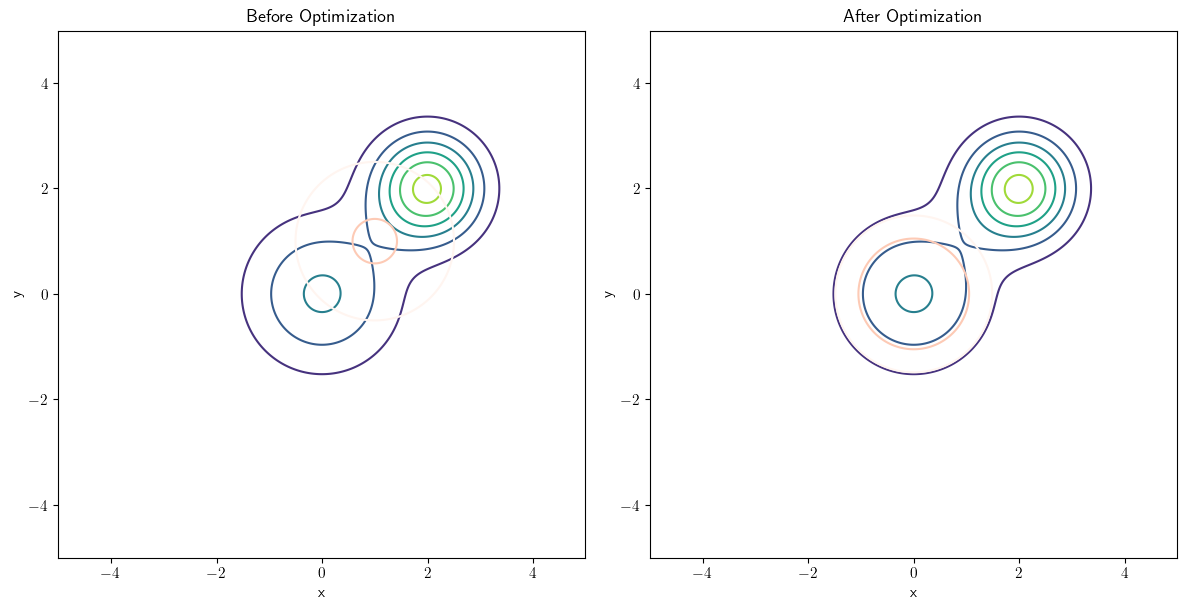

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal

# Set up the grid
x, y = np.mgrid[-5:5:.01, -5:5:.01]
pos = np.dstack((x, y))

# Define the true distribution
mu1 = np.array([0, 0])
sigma1 = np.array([[1, 0], [0, 1]])
mu2 = np.array([2, 2])
sigma2 = np.array([[0.5, 0], [0, 0.5]])
true_dist = multivariate_normal(mu1, sigma1).pdf(pos) + multivariate_normal(mu2, sigma2).pdf(pos)

# Define the variational distributions
var_mu1 = np.array([1, 1])
var_sigma1 = np.array([[1.5, 0], [0, 1.5]])
var_mu2 = np.array([0, 0])
var_sigma2 = np.array([[0.8, 0], [0, 0.8]])
var_dist1 = multivariate_normal(var_mu1, var_sigma1).pdf(pos)
var_dist2 = multivariate_normal(var_mu2, var_sigma2).pdf(pos)

# Create the subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Plot the true distribution
axs[0].contour(x, y, true_dist, cmap='viridis')
axs[1].contour(x, y, true_dist, cmap='viridis')

# Plot the variational distributions
axs[0].contour(x, y, var_dist1, cmap='Reds', levels=[0.05, 0.1, 0.2, 0.3])
axs[1].contour(x, y, var_dist2, cmap='Reds', levels=[0.05, 0.1, 0.2, 0.3])

# Set labels and titles
axs[0].set_title('Before Optimization')
axs[1].set_title('After Optimization')
for ax in axs:
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_aspect('equal')

plt.tight_layout()
plt.show()

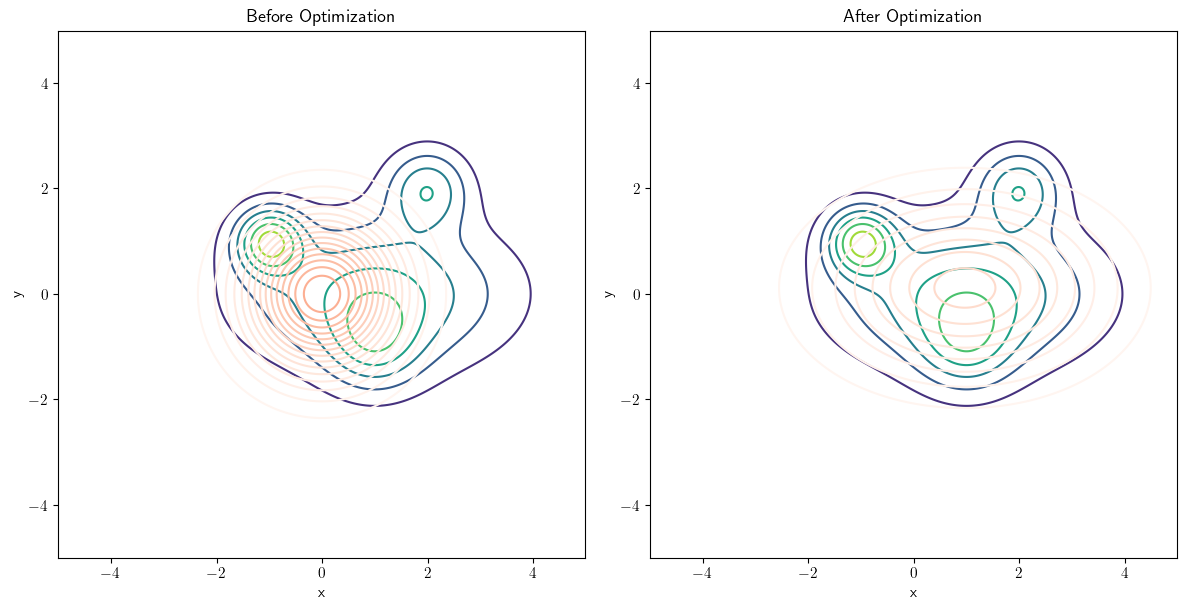

In [32]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
from scipy.optimize import minimize

# Set up the grid
x, y = np.mgrid[-5:5:.01, -5:5:.01]
pos = np.dstack((x, y))

# Define the true distribution (mixture of Gaussians)
mu1 = np.array([1, 0])
sigma1 = np.array([[3, 0], [0, 1]])
mu2 = np.array([2, 2])
sigma2 = np.array([[0.3, 0], [0, 0.3]])
mu3 = np.array([-1, 1])
sigma3 = np.array([[0.2, 0], [0, 0.2]])
mu4 = np.array([1, -1])
sigma4 = np.array([[0.4, 0], [0, 0.4]])
true_dist = (
    0.7 * multivariate_normal(mu1, sigma1).pdf(pos) +
    0.1 * multivariate_normal(mu2, sigma2).pdf(pos) +
    0.1 * multivariate_normal(mu3, sigma3).pdf(pos) +
    0.1 * multivariate_normal(mu4, sigma4).pdf(pos)
)

# Define the initial variational distribution
var_mu = np.array([0, 0])
var_sigma = np.array([[1, 0], [0, 1]])
var_dist = multivariate_normal(var_mu, var_sigma).pdf(pos)

# Define the KL divergence objective function
def kl_divergence(params):
    mu = params[:2]
    sigma = np.array([[params[2], 0], [0, params[3]]])
    var_dist = multivariate_normal(mu, sigma).pdf(pos)
    kl_div = np.sum(var_dist * (np.log(var_dist) - np.log(true_dist))) * 0.01 * 0.01
    return kl_div

# Optimize the variational distribution
initial_params = np.array([0, 0, 1, 1])
result = minimize(kl_divergence, initial_params, method='BFGS')
optimized_mu = result.x[:2]
optimized_sigma = np.array([[result.x[2], 0], [0, result.x[3]]])
optimized_var_dist = multivariate_normal(optimized_mu, optimized_sigma).pdf(pos)

# Create the subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Plot the true distribution
axs[0].contour(x, y, true_dist, cmap='viridis')
axs[1].contour(x, y, true_dist, cmap='viridis')

# Plot the initial and optimized variational distributions
levels = np.linspace(0.01, 0.5, 50)
axs[0].contour(x, y, var_dist, cmap='Reds', levels=levels)
axs[1].contour(x, y, optimized_var_dist, cmap='Reds', levels=levels)

# Set labels and titles
axs[0].set_title('Before Optimization')
axs[1].set_title('After Optimization')
for ax in axs:
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_aspect('equal')

plt.tight_layout()
plt.show()

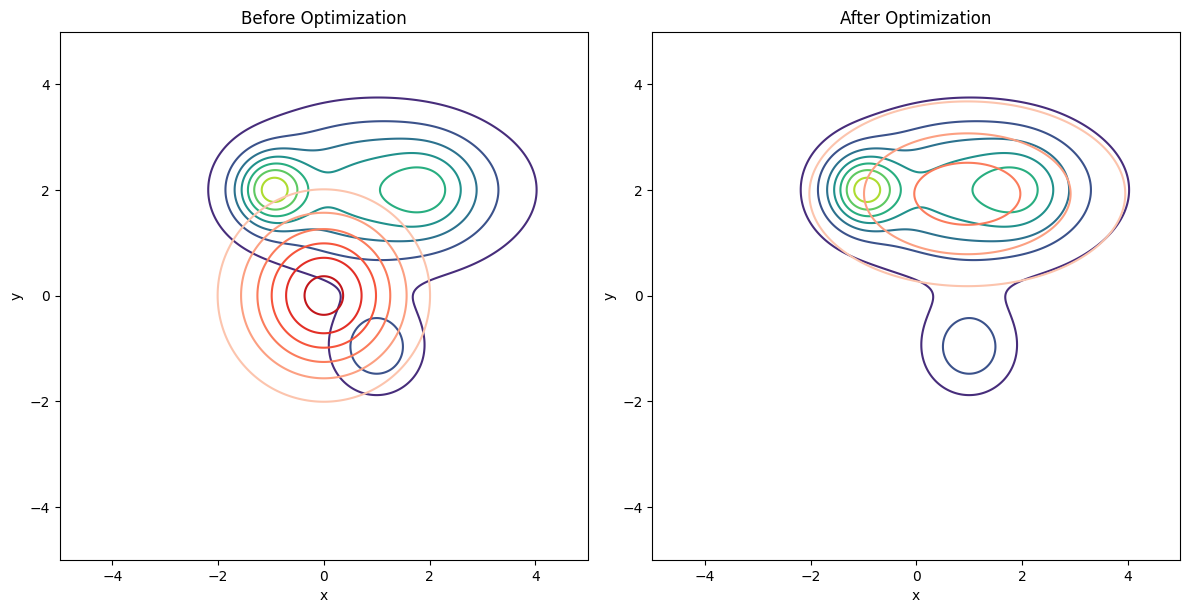

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
from scipy.optimize import minimize

# Set up the grid
x, y = np.mgrid[-5:5:.01, -5:5:.01]
pos = np.dstack((x, y))

# Define the true distribution (mixture of Gaussians)
mu1 = np.array([1, 2])
sigma1 = np.array([[3, 0], [0, 1]])
mu2 = np.array([2, 2])
sigma2 = np.array([[0.3, 0], [0, 0.3]])
mu3 = np.array([-1, 2])
sigma3 = np.array([[0.2, 0], [0, 0.2]])
mu4 = np.array([1, -1])
sigma4 = np.array([[0.4, 0], [0, 0.4]])
true_dist = (
    0.75 * multivariate_normal(mu1, sigma1).pdf(pos) +
    0.05 * multivariate_normal(mu2, sigma2).pdf(pos) +
    0.1 * multivariate_normal(mu3, sigma3).pdf(pos) +
    0.1 * multivariate_normal(mu4, sigma4).pdf(pos)
)

# Define the initial variational distribution
var_mu = np.array([0, 0])
var_sigma = np.array([[1, 0], [0, 1]])
var_dist = multivariate_normal(var_mu, var_sigma).pdf(pos)

# Define the KL divergence objective function
def kl_divergence(params):
    mu = params[:2]
    sigma = np.array([[params[2], 0], [0, params[3]]])
    var_dist = multivariate_normal(mu, sigma).pdf(pos)
    kl_div = np.sum(var_dist * (np.log(var_dist) - np.log(true_dist))) * 0.01 * 0.01
    return kl_div

# Optimize the variational distribution
initial_params = np.array([0, 0, 1, 1])
result = minimize(kl_divergence, initial_params, method='BFGS')
optimized_mu = result.x[:2]
optimized_sigma = np.array([[result.x[2], 0], [0, result.x[3]]])
optimized_var_dist = multivariate_normal(optimized_mu, optimized_sigma).pdf(pos)

# Create the subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Plot the true distribution
axs[0].contour(x, y, true_dist, cmap='viridis')
axs[1].contour(x, y, true_dist, cmap='viridis')

# Plot the initial and optimized variational distributions
levels = np.linspace(-0.03, 0.2, 10)  # Adjusted levels for better visibility
axs[0].contour(x, y, var_dist, cmap='Reds', levels=levels)
axs[1].contour(x, y, optimized_var_dist, cmap='Reds', levels=levels)

# Set labels and titles
axs[0].set_title('Before Optimization')
axs[1].set_title('After Optimization')
for ax in axs:
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_aspect('equal')

plt.tight_layout()
plt.show()

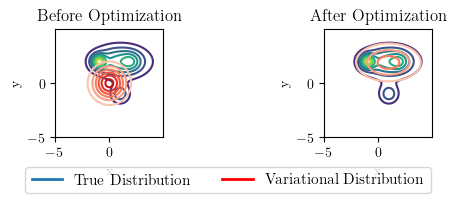

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
from scipy.optimize import minimize
from matplotlib import rc

# Set up the grid
x, y = np.mgrid[-5:5:.01, -5:5:.01]
pos = np.dstack((x, y))

# Define the true distribution (mixture of Gaussians)
mu1 = np.array([1, 2])
sigma1 = np.array([[3, 0], [0, 1]])
mu2 = np.array([2, 2])
sigma2 = np.array([[0.3, 0], [0, 0.3]])
mu3 = np.array([-1, 2])
sigma3 = np.array([[0.2, 0], [0, 0.2]])
mu4 = np.array([1, -1])
sigma4 = np.array([[0.4, 0], [0, 0.4]])
true_dist = (
    0.75 * multivariate_normal(mu1, sigma1).pdf(pos) +
    0.05 * multivariate_normal(mu2, sigma2).pdf(pos) +
    0.1 * multivariate_normal(mu3, sigma3).pdf(pos) +
    0.1 * multivariate_normal(mu4, sigma4).pdf(pos)
)

# Define the initial variational distribution
var_mu = np.array([0, 0])
var_sigma = np.array([[1, 0], [0, 1]])
var_dist = multivariate_normal(var_mu, var_sigma).pdf(pos)

# Define the KL divergence objective function
def kl_divergence(params):
    mu = params[:2]
    sigma = np.array([[params[2], 0], [0, params[3]]])
    var_dist = multivariate_normal(mu, sigma).pdf(pos)
    kl_div = np.sum(var_dist * (np.log(var_dist) - np.log(true_dist))) * 0.01 * 0.01
    return kl_div

# Optimize the variational distribution
initial_params = np.array([0, 0, 1, 1])
result = minimize(kl_divergence, initial_params, method='BFGS')
optimized_mu = result.x[:2]
optimized_sigma = np.array([[result.x[2], 0], [0, result.x[3]]])
optimized_var_dist = multivariate_normal(optimized_mu, optimized_sigma).pdf(pos)

# Set font to Computer Modern
rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)

# Create the subplots
fig, axs = plt.subplots(1, 2, figsize=(5.7, 2.15))

# Plot the true distribution
axs[0].contour(x, y, true_dist, cmap='viridis')
axs[1].contour(x, y, true_dist, cmap='viridis')

# Plot the initial and optimized variational distributions
levels = np.linspace(-0.03, 0.2, 10)  # Adjusted levels for better visibility
axs[0].contour(x, y, var_dist, cmap='Reds', levels=levels)
axs[1].contour(x, y, optimized_var_dist, cmap='Reds', levels=levels)

# Set labels and titles
axs[0].set_title('Before Optimization')
axs[1].set_title('After Optimization')
for ax in axs:
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_aspect('equal')

# Create legend
legend_elements = [plt.Line2D([0], [0], color='C0', lw=2, label='True Distribution'),
                   plt.Line2D([0], [0], color='red', lw=2, label='Variational Distribution')]
legend = fig.legend(handles=legend_elements, ncol=2, loc='lower center', fontsize=11)

# Adjust layout and save the figure
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig('./plots/variational_inference_schematic.pdf', dpi=300, bbox_extra_artists=(legend,), bbox_inches='tight')
plt.show()

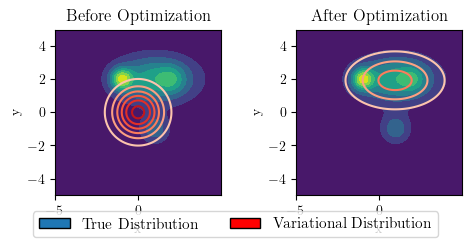

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
from scipy.optimize import minimize
from matplotlib import rc
from matplotlib.patches import Patch

# Set up the grid
x, y = np.mgrid[-5:5:.01, -5:5:.01]
pos = np.dstack((x, y))

# Define the true distribution (mixture of Gaussians)
mu1 = np.array([1, 2])
sigma1 = np.array([[3, 0], [0, 1]])
mu2 = np.array([2, 2])
sigma2 = np.array([[0.3, 0], [0, 0.3]])
mu3 = np.array([-1, 2])
sigma3 = np.array([[0.2, 0], [0, 0.2]])
mu4 = np.array([1, -1])
sigma4 = np.array([[0.4, 0], [0, 0.4]])
true_dist = (
    0.75 * multivariate_normal(mu1, sigma1).pdf(pos) +
    0.05 * multivariate_normal(mu2, sigma2).pdf(pos) +
    0.1 * multivariate_normal(mu3, sigma3).pdf(pos) +
    0.1 * multivariate_normal(mu4, sigma4).pdf(pos)
)

# Define the initial variational distribution
var_mu = np.array([0, 0])
var_sigma = np.array([[1, 0], [0, 1]])
var_dist = multivariate_normal(var_mu, var_sigma).pdf(pos)

# Define the KL divergence objective function
def kl_divergence(params):
    mu = params[:2]
    sigma = np.array([[params[2], 0], [0, params[3]]])
    var_dist = multivariate_normal(mu, sigma).pdf(pos)
    kl_div = np.sum(var_dist * (np.log(var_dist) - np.log(true_dist))) * 0.01 * 0.01
    return kl_div

# Optimize the variational distribution
initial_params = np.array([0, 0, 1, 1])
result = minimize(kl_divergence, initial_params, method='BFGS')
optimized_mu = result.x[:2]
optimized_sigma = np.array([[result.x[2], 0], [0, result.x[3]]])
optimized_var_dist = multivariate_normal(optimized_mu, optimized_sigma).pdf(pos)

# Set font to Computer Modern
rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)

# Create the subplots with reduced spacing
fig, axs = plt.subplots(1, 2, figsize=(5.7, 2.15))

# Plot the true distribution
axs[0].contourf(x, y, true_dist, cmap='viridis')
axs[1].contourf(x, y, true_dist, cmap='viridis')

# Plot the initial and optimized variational distributions
levels = np.linspace(-0.03, 0.2, 10)  # Adjusted levels for better visibility
axs[0].contour(x, y, var_dist, cmap='Reds', levels=levels)
axs[1].contour(x, y, optimized_var_dist, cmap='Reds', levels=levels)

# Set labels and titles
axs[0].set_title('Before Optimization')
axs[1].set_title('After Optimization')
for ax in axs:
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_aspect('equal')

# Create legend
legend_elements = [Patch(facecolor='#1f77b4', edgecolor='black', label='True Distribution'),
                   Patch(facecolor='red', edgecolor='black', label='Variational Distribution')]
legend = fig.legend(handles=legend_elements, ncol=2, loc='lower center', fontsize=11)

# Adjust layout and save the figure
# plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig('./plots/variational_inference_schematic.pdf', dpi=300, bbox_extra_artists=(legend,), bbox_inches='tight')
plt.show()

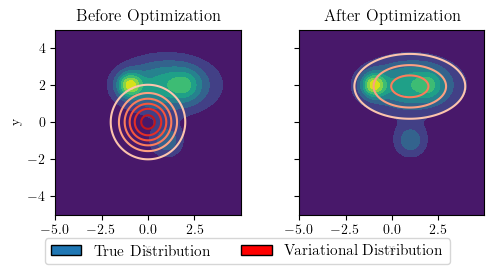

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
from scipy.optimize import minimize
from matplotlib import rc
from matplotlib.patches import Patch

# Set up the grid
x, y = np.mgrid[-5:5:.01, -5:5:.01]
pos = np.dstack((x, y))

# Define the true distribution (mixture of Gaussians)
mu1 = np.array([1, 2])
sigma1 = np.array([[3, 0], [0, 1]])
mu2 = np.array([2, 2])
sigma2 = np.array([[0.3, 0], [0, 0.3]])
mu3 = np.array([-1, 2])
sigma3 = np.array([[0.2, 0], [0, 0.2]])
mu4 = np.array([1, -1])
sigma4 = np.array([[0.4, 0], [0, 0.4]])
true_dist = (
    0.75 * multivariate_normal(mu1, sigma1).pdf(pos) +
    0.05 * multivariate_normal(mu2, sigma2).pdf(pos) +
    0.1 * multivariate_normal(mu3, sigma3).pdf(pos) +
    0.1 * multivariate_normal(mu4, sigma4).pdf(pos)
)

# Define the initial variational distribution
var_mu = np.array([0, 0])
var_sigma = np.array([[1, 0], [0, 1]])
var_dist = multivariate_normal(var_mu, var_sigma).pdf(pos)

# Define the KL divergence objective function
def kl_divergence(params):
    mu = params[:2]
    sigma = np.array([[params[2], 0], [0, params[3]]])
    var_dist = multivariate_normal(mu, sigma).pdf(pos)
    kl_div = np.sum(var_dist * (np.log(var_dist) - np.log(true_dist))) * 0.01 * 0.01
    return kl_div

# Optimize the variational distribution
initial_params = np.array([0, 0, 1, 1])
result = minimize(kl_divergence, initial_params, method='BFGS')
optimized_mu = result.x[:2]
optimized_sigma = np.array([[result.x[2], 0], [0, result.x[3]]])
optimized_var_dist = multivariate_normal(optimized_mu, optimized_sigma).pdf(pos)

# Set font to Computer Modern
rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)

# Create the subplots
fig, axs = plt.subplots(1, 2, figsize=(5.7, 2.75))

# Plot the true distribution
axs[0].contourf(x, y, true_dist, cmap='viridis')
axs[1].contourf(x, y, true_dist, cmap='viridis')

# Plot the initial and optimized variational distributions
levels = np.linspace(-0.03, 0.2, 10)  # Adjusted levels for better visibility
axs[0].contour(x, y, var_dist, cmap='Reds', levels=levels)
axs[1].contour(x, y, optimized_var_dist, cmap='Reds', levels=levels)

# Set labels and titles
axs[0].set_title('Before Optimization')
axs[1].set_title('After Optimization')
axs[0].set_xlabel('x')
axs[0].set_ylabel('y')
axs[1].set_xlabel('x')
axs[1].tick_params(labelleft=False)
for ax in axs:
    ax.set_aspect('equal')

# Create legend
legend_elements = [Patch(facecolor='#1f77b4', edgecolor='black', label='True Distribution'),
                   Patch(facecolor='red', edgecolor='black', label='Variational Distribution')]
legend = fig.legend(handles=legend_elements, ncol=2, loc='lower center', fontsize=11)

# Adjust layout and save the figure
plt.subplots_adjust(wspace=0.0, bottom=0.3)  # Adjust the spacing and positioning here
plt.tight_layout()
plt.savefig('./plots/variational_inference_schematic.pdf', dpi=300, bbox_extra_artists=(legend,), bbox_inches='tight')
plt.show()

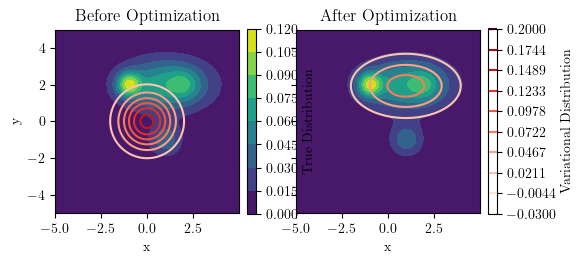

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
from scipy.optimize import minimize
from matplotlib import rc

# Set up the grid
x, y = np.mgrid[-5:5:.01, -5:5:.01]
pos = np.dstack((x, y))

# Define the true distribution (mixture of Gaussians)
mu1 = np.array([1, 2])
sigma1 = np.array([[3, 0], [0, 1]])
mu2 = np.array([2, 2])
sigma2 = np.array([[0.3, 0], [0, 0.3]])
mu3 = np.array([-1, 2])
sigma3 = np.array([[0.2, 0], [0, 0.2]])
mu4 = np.array([1, -1])
sigma4 = np.array([[0.4, 0], [0, 0.4]])
true_dist = (
    0.75 * multivariate_normal(mu1, sigma1).pdf(pos) +
    0.05 * multivariate_normal(mu2, sigma2).pdf(pos) +
    0.1 * multivariate_normal(mu3, sigma3).pdf(pos) +
    0.1 * multivariate_normal(mu4, sigma4).pdf(pos)
)

# Define the initial variational distribution
var_mu = np.array([0, 0])
var_sigma = np.array([[1, 0], [0, 1]])
var_dist = multivariate_normal(var_mu, var_sigma).pdf(pos)

# Define the KL divergence objective function
def kl_divergence(params):
    mu = params[:2]
    sigma = np.array([[params[2], 0], [0, params[3]]])
    var_dist = multivariate_normal(mu, sigma).pdf(pos)
    kl_div = np.sum(var_dist * (np.log(var_dist) - np.log(true_dist))) * 0.01 * 0.01
    return kl_div

# Optimize the variational distribution
initial_params = np.array([0, 0, 1, 1])
result = minimize(kl_divergence, initial_params, method='BFGS')
optimized_mu = result.x[:2]
optimized_sigma = np.array([[result.x[2], 0], [0, result.x[3]]])
optimized_var_dist = multivariate_normal(optimized_mu, optimized_sigma).pdf(pos)

# Set font to Computer Modern
rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)

# Create the subplots
fig, axs = plt.subplots(1, 2, figsize=(5.7, 2.75))

# Plot the true distribution
axs[0].contourf(x, y, true_dist, cmap='viridis')
axs[1].contourf(x, y, true_dist, cmap='viridis')

# Plot the initial and optimized variational distributions
levels = np.linspace(-0.03, 0.2, 10)  # Adjusted levels for better visibility
axs[0].contour(x, y, var_dist, cmap='Reds', levels=levels)
axs[1].contour(x, y, optimized_var_dist, cmap='Reds', levels=levels)

# Set labels and titles
axs[0].set_title('Before Optimization')
axs[1].set_title('After Optimization')
axs[0].set_xlabel('x')
axs[0].set_ylabel('y')
axs[1].set_xlabel('x')
axs[1].tick_params(labelleft=False)
for ax in axs:
    ax.set_aspect('equal')

# Add colorbars
cbar_true = fig.colorbar(axs[0].collections[0], ax=axs[0], fraction=0.046, pad=0.04, label='True Distribution')
cbar_var = fig.colorbar(axs[1].collections[1], ax=axs[1], fraction=0.046, pad=0.04, label='Variational Distribution')

# Adjust layout and save the figure
plt.subplots_adjust(wspace=0.2, bottom=0.2)  # Adjust the spacing and positioning here
plt.savefig('./plots/variational_inference_schematic.pdf', dpi=300, bbox_inches='tight')
plt.show()

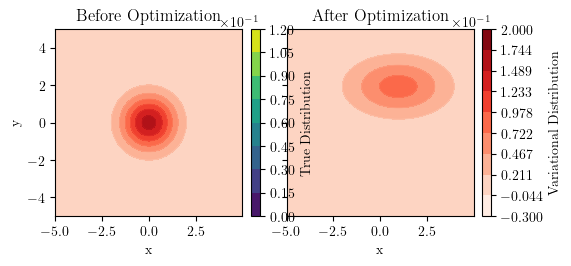

In [28]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
from scipy.optimize import minimize
from matplotlib import rc

# Set up the grid
x, y = np.mgrid[-5:5:.01, -5:5:.01]
pos = np.dstack((x, y))

# Define the true distribution (mixture of Gaussians)
mu1 = np.array([1, 2])
sigma1 = np.array([[3, 0], [0, 1]])
mu2 = np.array([2, 2])
sigma2 = np.array([[0.3, 0], [0, 0.3]])
mu3 = np.array([-1, 2])
sigma3 = np.array([[0.2, 0], [0, 0.2]])
mu4 = np.array([1, -1])
sigma4 = np.array([[0.4, 0], [0, 0.4]])
true_dist = (
    0.75 * multivariate_normal(mu1, sigma1).pdf(pos) +
    0.05 * multivariate_normal(mu2, sigma2).pdf(pos) +
    0.1 * multivariate_normal(mu3, sigma3).pdf(pos) +
    0.1 * multivariate_normal(mu4, sigma4).pdf(pos)
)

# Define the initial variational distribution
var_mu = np.array([0, 0])
var_sigma = np.array([[1, 0], [0, 1]])
var_dist = multivariate_normal(var_mu, var_sigma).pdf(pos)

# Define the KL divergence objective function
def kl_divergence(params):
    mu = params[:2]
    sigma = np.array([[params[2], 0], [0, params[3]]])
    var_dist = multivariate_normal(mu, sigma).pdf(pos)
    kl_div = np.sum(var_dist * (np.log(var_dist) - np.log(true_dist))) * 0.01 * 0.01
    return kl_div

# Optimize the variational distribution
initial_params = np.array([0, 0, 1, 1])
result = minimize(kl_divergence, initial_params, method='BFGS')
optimized_mu = result.x[:2]
optimized_sigma = np.array([[result.x[2], 0], [0, result.x[3]]])
optimized_var_dist = multivariate_normal(optimized_mu, optimized_sigma).pdf(pos)

# Set font to Computer Modern
rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)

# Create the subplots
fig, axs = plt.subplots(1, 2, figsize=(5.7, 2.75))

# Plot the true distribution
axs[0].contourf(x, y, true_dist, cmap='viridis')
axs[1].contourf(x, y, true_dist, cmap='viridis')

# Plot the initial and optimized variational distributions
levels = np.linspace(-0.03, 0.2, 10)  # Adjusted levels for better visibility
cont_var_init = axs[0].contourf(x, y, var_dist, cmap='Reds', alpha=1.0, levels=levels)
cont_var_opt = axs[1].contourf(x, y, optimized_var_dist, cmap='Reds', alpha=1.0, levels=levels)
axs[0].contour(x, y, var_dist, levels=levels, cmap='Reds', linewidths=0.5)
axs[1].contour(x, y, optimized_var_dist, levels=levels, cmap='Reds', linewidths=0.5)

# Set labels and titles
axs[0].set_title('Before Optimization')
axs[1].set_title('After Optimization')
axs[0].set_xlabel('x')
axs[0].set_ylabel('y')
axs[1].set_xlabel('x')
axs[1].tick_params(labelleft=False)
for ax in axs:
    ax.set_aspect('equal')

# Add colorbars
cbar_true = fig.colorbar(axs[0].collections[0], ax=axs[0], fraction=0.046, pad=0.04, label='True Distribution')
cbar_var = fig.colorbar(cont_var_opt, ax=axs[1], fraction=0.046, pad=0.04, label='Variational Distribution')

# Format colorbar ticks
cbar_true.formatter.set_powerlimits((0, 0))
cbar_true.update_ticks()
cbar_var.formatter.set_powerlimits((0, 0))
cbar_var.update_ticks()

# Adjust layout and save the figure
plt.subplots_adjust(wspace=0.1, bottom=0.2)  # Adjust the spacing and positioning here
plt.savefig('./plots/variational_inference_schematic.pdf', dpi=300, bbox_inches='tight')
plt.show()

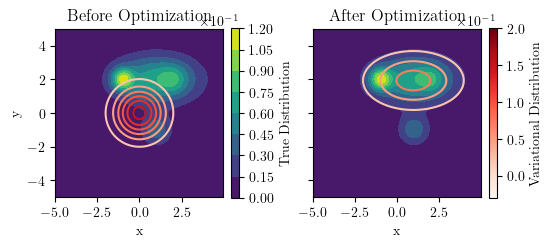

In [30]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
from scipy.optimize import minimize
from matplotlib import rc
from matplotlib.colors import ListedColormap

# Set up the grid
x, y = np.mgrid[-5:5:.01, -5:5:.01]
pos = np.dstack((x, y))

# Define the true distribution (mixture of Gaussians)
mu1 = np.array([1, 2])
sigma1 = np.array([[3, 0], [0, 1]])
mu2 = np.array([2, 2])
sigma2 = np.array([[0.3, 0], [0, 0.3]])
mu3 = np.array([-1, 2])
sigma3 = np.array([[0.2, 0], [0, 0.2]])
mu4 = np.array([1, -1])
sigma4 = np.array([[0.4, 0], [0, 0.4]])
true_dist = (
    0.75 * multivariate_normal(mu1, sigma1).pdf(pos) +
    0.05 * multivariate_normal(mu2, sigma2).pdf(pos) +
    0.1 * multivariate_normal(mu3, sigma3).pdf(pos) +
    0.1 * multivariate_normal(mu4, sigma4).pdf(pos)
)

# Define the initial variational distribution
var_mu = np.array([0, 0])
var_sigma = np.array([[1, 0], [0, 1]])
var_dist = multivariate_normal(var_mu, var_sigma).pdf(pos)

# Define the KL divergence objective function
def kl_divergence(params):
    mu = params[:2]
    sigma = np.array([[params[2], 0], [0, params[3]]])
    var_dist = multivariate_normal(mu, sigma).pdf(pos)
    kl_div = np.sum(var_dist * (np.log(var_dist) - np.log(true_dist))) * 0.01 * 0.01
    return kl_div

# Optimize the variational distribution
initial_params = np.array([0, 0, 1, 1])
result = minimize(kl_divergence, initial_params, method='BFGS')
optimized_mu = result.x[:2]
optimized_sigma = np.array([[result.x[2], 0], [0, result.x[3]]])
optimized_var_dist = multivariate_normal(optimized_mu, optimized_sigma).pdf(pos)

# Set font to Computer Modern
rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)

# Create the subplots
fig, axs = plt.subplots(1, 2, figsize=(5.7, 2.75))

# Plot the true distribution
axs[0].contourf(x, y, true_dist, cmap='viridis')
axs[1].contourf(x, y, true_dist, cmap='viridis')

# Plot the initial and optimized variational distributions
levels = np.linspace(-0.03, 0.2, 10)  # Adjusted levels for better visibility
axs[0].contour(x, y, var_dist, cmap='Reds', levels=levels)
axs[1].contour(x, y, optimized_var_dist, cmap='Reds', levels=levels)

# Create a filled colorbar for the variational distribution
var_cmap = plt.cm.Reds
var_cmap_filled = ListedColormap(var_cmap(np.linspace(0, 1, 256)))
sm_var = plt.cm.ScalarMappable(cmap=var_cmap_filled, norm=plt.Normalize(vmin=levels[0], vmax=levels[-1]))
sm_var.set_array([])

# Set labels and titles
axs[0].set_title('Before Optimization')
axs[1].set_title('After Optimization')
axs[0].set_xlabel('x')
axs[0].set_ylabel('y')
axs[1].set_xlabel('x')
axs[1].tick_params(labelleft=False)
for ax in axs:
    ax.set_aspect('equal')

# Add colorbars
cbar_true = fig.colorbar(axs[0].collections[0], ax=axs[0], fraction=0.046, pad=0.04, label='True Distribution')
cbar_var = fig.colorbar(sm_var, ax=axs[1], fraction=0.046, pad=0.04, label='Variational Distribution')

# Format colorbar ticks
cbar_true.formatter.set_powerlimits((0, 0))
cbar_true.update_ticks()
cbar_var.formatter.set_powerlimits((0, 0))
cbar_var.update_ticks()

# Adjust layout and save the figure
plt.subplots_adjust(wspace=0.4, bottom=0.2)  # Adjust the spacing and positioning here
plt.savefig('./plots/variational_inference_schematic.pdf', dpi=300, bbox_inches='tight')
plt.show()

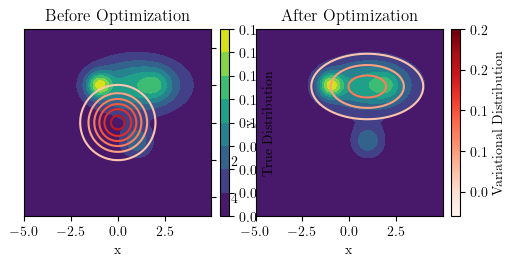

In [31]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
from scipy.optimize import minimize
from matplotlib import rc
from matplotlib.colors import ListedColormap
from matplotlib.ticker import FormatStrFormatter

# Set up the grid
x, y = np.mgrid[-5:5:.01, -5:5:.01]
pos = np.dstack((x, y))

# Define the true distribution (mixture of Gaussians)
mu1 = np.array([1, 2])
sigma1 = np.array([[3, 0], [0, 1]])
mu2 = np.array([2, 2])
sigma2 = np.array([[0.3, 0], [0, 0.3]])
mu3 = np.array([-1, 2])
sigma3 = np.array([[0.2, 0], [0, 0.2]])
mu4 = np.array([1, -1])
sigma4 = np.array([[0.4, 0], [0, 0.4]])
true_dist = (
    0.75 * multivariate_normal(mu1, sigma1).pdf(pos) +
    0.05 * multivariate_normal(mu2, sigma2).pdf(pos) +
    0.1 * multivariate_normal(mu3, sigma3).pdf(pos) +
    0.1 * multivariate_normal(mu4, sigma4).pdf(pos)
)

# Define the initial variational distribution
var_mu = np.array([0, 0])
var_sigma = np.array([[1, 0], [0, 1]])
var_dist = multivariate_normal(var_mu, var_sigma).pdf(pos)

# Define the KL divergence objective function
def kl_divergence(params):
    mu = params[:2]
    sigma = np.array([[params[2], 0], [0, params[3]]])
    var_dist = multivariate_normal(mu, sigma).pdf(pos)
    kl_div = np.sum(var_dist * (np.log(var_dist) - np.log(true_dist))) * 0.01 * 0.01
    return kl_div

# Optimize the variational distribution
initial_params = np.array([0, 0, 1, 1])
result = minimize(kl_divergence, initial_params, method='BFGS')
optimized_mu = result.x[:2]
optimized_sigma = np.array([[result.x[2], 0], [0, result.x[3]]])
optimized_var_dist = multivariate_normal(optimized_mu, optimized_sigma).pdf(pos)

# Set font to Computer Modern
rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)

# Create the subplots
fig, axs = plt.subplots(1, 2, figsize=(5.7, 2.75))

# Plot the true distribution
im_true = axs[0].contourf(x, y, true_dist, cmap='viridis')
axs[1].contourf(x, y, true_dist, cmap='viridis')

# Plot the initial and optimized variational distributions
levels = np.linspace(-0.03, 0.2, 10)  # Adjusted levels for better visibility
axs[0].contour(x, y, var_dist, cmap='Reds', levels=levels)
axs[1].contour(x, y, optimized_var_dist, cmap='Reds', levels=levels)

# Create a filled colorbar for the variational distribution
var_cmap = plt.cm.Reds
var_cmap_filled = ListedColormap(var_cmap(np.linspace(0, 1, 256)))
sm_var = plt.cm.ScalarMappable(cmap=var_cmap_filled, norm=plt.Normalize(vmin=levels[0], vmax=levels[-1]))
sm_var.set_array([])

# Set labels and titles
axs[0].set_title('Before Optimization')
axs[1].set_title('After Optimization')
axs[0].set_xlabel('x')
axs[1].set_xlabel('x')

# Move y-axis to the right of the left plot
axs[0].yaxis.tick_right()
axs[0].yaxis.set_label_position("right")
axs[0].set_ylabel('y')

# Remove y-axis from the right plot
axs[1].tick_params(labelleft=False, left=False)

for ax in axs:
    ax.set_aspect('equal')

# Add colorbars
cbar_true = fig.colorbar(im_true, ax=axs[0], fraction=0.046, pad=0.04, label='True Distribution')
cbar_var = fig.colorbar(sm_var, ax=axs[1], fraction=0.046, pad=0.04, label='Variational Distribution')

# Format colorbar ticks with 1 decimal place
cbar_true.formatter = FormatStrFormatter('%.1f')
cbar_true.update_ticks()
cbar_var.formatter = FormatStrFormatter('%.1f')
cbar_var.update_ticks()

# Adjust layout and save the figure
plt.subplots_adjust(wspace=0.1, bottom=0.2)  # Adjust the spacing and positioning here
plt.savefig('./plots/variational_inference_schematic.pdf', dpi=300, bbox_inches='tight')
plt.show()

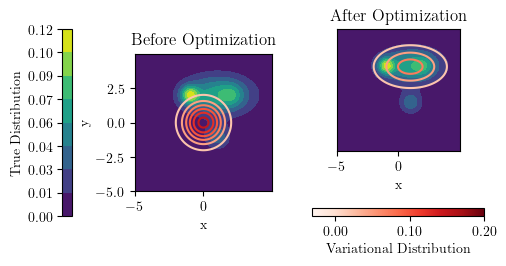

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
from scipy.optimize import minimize
from matplotlib import rc
from matplotlib.colors import ListedColormap
from matplotlib.ticker import FormatStrFormatter

# Set up the grid
x, y = np.mgrid[-5:5:.01, -5:5:.01]
pos = np.dstack((x, y))

# Define the true distribution (mixture of Gaussians)
mu1 = np.array([1, 2])
sigma1 = np.array([[3, 0], [0, 1]])
mu2 = np.array([2, 2])
sigma2 = np.array([[0.3, 0], [0, 0.3]])
mu3 = np.array([-1, 2])
sigma3 = np.array([[0.2, 0], [0, 0.2]])
mu4 = np.array([1, -1])
sigma4 = np.array([[0.4, 0], [0, 0.4]])
true_dist = (
    0.75 * multivariate_normal(mu1, sigma1).pdf(pos) +
    0.05 * multivariate_normal(mu2, sigma2).pdf(pos) +
    0.1 * multivariate_normal(mu3, sigma3).pdf(pos) +
    0.1 * multivariate_normal(mu4, sigma4).pdf(pos)
)

# Define the initial variational distribution
var_mu = np.array([0, 0])
var_sigma = np.array([[1, 0], [0, 1]])
var_dist = multivariate_normal(var_mu, var_sigma).pdf(pos)

# Define the KL divergence objective function
def kl_divergence(params):
    mu = params[:2]
    sigma = np.array([[params[2], 0], [0, params[3]]])
    var_dist = multivariate_normal(mu, sigma).pdf(pos)
    kl_div = np.sum(var_dist * (np.log(var_dist) - np.log(true_dist))) * 0.01 * 0.01
    return kl_div

# Optimize the variational distribution
initial_params = np.array([0, 0, 1, 1])
result = minimize(kl_divergence, initial_params, method='BFGS')
optimized_mu = result.x[:2]
optimized_sigma = np.array([[result.x[2], 0], [0, result.x[3]]])
optimized_var_dist = multivariate_normal(optimized_mu, optimized_sigma).pdf(pos)

# Set font to Computer Modern
rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)

# Create the subplots
fig, axs = plt.subplots(1, 2, figsize=(5.7, 2.75))

# Plot the true distribution
im_true = axs[0].contourf(x, y, true_dist, cmap='viridis')
axs[1].contourf(x, y, true_dist, cmap='viridis')

# Plot the initial and optimized variational distributions
levels = np.linspace(-0.03, 0.2, 10)  # Adjusted levels for better visibility
axs[0].contour(x, y, var_dist, cmap='Reds', levels=levels)
axs[1].contour(x, y, optimized_var_dist, cmap='Reds', levels=levels)

# Create a filled colorbar for the variational distribution
var_cmap = plt.cm.Reds
var_cmap_filled = ListedColormap(var_cmap(np.linspace(0, 1, 256)))
sm_var = plt.cm.ScalarMappable(cmap=var_cmap_filled, norm=plt.Normalize(vmin=levels[0], vmax=levels[-1]))
sm_var.set_array([])

# Set labels and titles
axs[0].set_title('Before Optimization')
axs[1].set_title('After Optimization')
axs[0].set_xlabel('x')
axs[1].set_xlabel('x')

# Move y-axis to the right of the left plot
axs[0].yaxis.tick_right()
axs[0].yaxis.set_label_position("right")
axs[0].set_ylabel('y')

# Remove y-axis from the right plot
axs[1].tick_params(labelleft=False, left=False)

for ax in axs:
    ax.set_aspect('equal')

# Add colorbars
cbar_true = fig.colorbar(im_true, ax=axs[0], fraction=0.046, pad=0.3, label='True Distribution', location='left', orientation='vertical')
cbar_var = fig.colorbar(sm_var, ax=axs[1], fraction=0.046, pad=0.3, label='Variational Distribution', location='right', orientation='vertical')

# Move the colorbar for the true distribution to the left and mirror it
cbar_true.ax.yaxis.set_ticks_position('left')
cbar_true.ax.yaxis.set_label_position('left')
cbar_true.ax.yaxis.set_ticks_position('left')

# Format colorbar ticks with 1 decimal place
cbar_true.formatter = FormatStrFormatter('%.2f')
cbar_true.update_ticks()
cbar_var.formatter = FormatStrFormatter('%.2f')
cbar_var.update_ticks()

# Adjust layout and save the figure
plt.subplots_adjust(wspace=0.1, bottom=0.2)  # Adjust the spacing and positioning here
plt.savefig('./plots/variational_inference_schematic.pdf', dpi=300, bbox_inches='tight')
plt.show()

AttributeError: 'function' object has no attribute 'legend_artist'

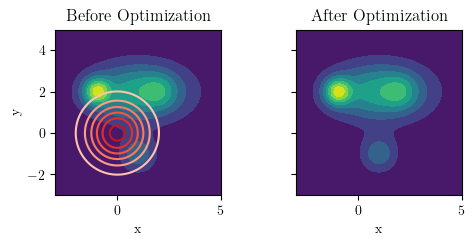

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
from scipy.optimize import minimize
from matplotlib import rc
from matplotlib.patches import Rectangle

# Set up the grid
x, y = np.mgrid[-3:5:.01, -3:5:.01]
pos = np.dstack((x, y))

# Define the true distribution (mixture of Gaussians)
mu1 = np.array([1, 2])
sigma1 = np.array([[3, 0], [0, 1]])
mu2 = np.array([2, 2])
sigma2 = np.array([[0.3, 0], [0, 0.3]])
mu3 = np.array([-1, 2])
sigma3 = np.array([[0.2, 0], [0, 0.2]])
mu4 = np.array([1, -1])
sigma4 = np.array([[0.4, 0], [0, 0.4]])
true_dist = (
    0.75 * multivariate_normal(mu1, sigma1).pdf(pos) +
    0.05 * multivariate_normal(mu2, sigma2).pdf(pos) +
    0.1 * multivariate_normal(mu3, sigma3).pdf(pos) +
    0.1 * multivariate_normal(mu4, sigma4).pdf(pos)
)

# Define the initial variational distribution
var_mu = np.array([0, 0])
var_sigma = np.array([[1, 0], [0, 1]])
var_dist = multivariate_normal(var_mu, var_sigma).pdf(pos)

# Define the KL divergence objective function
def kl_divergence(params):
    mu = params[:2]
    sigma = np.array([[params[2], 0], [0, params[3]]])
    var_dist = multivariate_normal(mu, sigma).pdf(pos)
    kl_div = np.sum(var_dist * (np.log(var_dist) - np.log(true_dist))) * 0.01 * 0.01
    return kl_div

# Optimize the variational distribution
initial_params = np.array([0, 0, 1, 1])
result = minimize(kl_divergence, initial_params, method='BFGS')
optimized_mu = result.x[:2]
optimized_sigma = np.array([[result.x[2], 0], [0, result.x[3]]])
optimized_var_dist = multivariate_normal(optimized_mu, optimized_sigma).pdf(pos)

# Set font to Computer Modern
rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)

# Create the subplots
fig, axs = plt.subplots(1, 2, figsize=(5.7, 2.15))

# Plot the true distribution
axs[0].contourf(x, y, true_dist, cmap='viridis')
axs[1].contourf(x, y, true_dist, cmap='viridis')

# Plot the initial and optimized variational distributions
levels = np.linspace(-0.03, 0.2, 10)  # Adjusted levels for better visibility
axs[0].contour(x, y, var_dist, cmap='Reds', levels=levels)
axs[1].contour(x, y, optimized_var_dist, cmap='Reds', levels=levels)

# Set labels and titles
axs[0].set_title('Before Optimization')
axs[1].set_title('After Optimization')
axs[0].set_xlabel('x')
axs[0].set_ylabel('y')
axs[1].set_xlabel('x')
axs[1].tick_params(labelleft=False)
for ax in axs:
    ax.set_aspect('equal')
    ax.set_xlim(-3, 5)
    ax.set_ylim(-3, 5)

# Create legend
legend_elements = [Rectangle((0, 0), 1, 1, facecolor='w', edgecolor='black', label='True Distribution'),
                   Rectangle((0, 0), 1, 1, facecolor='w', edgecolor='black', label='Variational Distribution')]

# Create colorbars for the legend
cmap_true = plt.cm.viridis
cmap_var = plt.cm.Reds
sm_true = plt.cm.ScalarMappable(cmap=cmap_true)
sm_var = plt.cm.ScalarMappable(cmap=cmap_var)
sm_true.set_array([])
sm_var.set_array([])

# Add colorbars to the legend
legend = fig.legend(handles=legend_elements, ncol=2, loc='lower center', fontsize=11,
                    handler_map={Rectangle: lambda *args, **kwargs: Rectangle(*args, **kwargs, width=0.3, height=0.3)})
legend.get_frame().set_linewidth(0.5)
legend.get_frame().set_edgecolor('black')

cbar_true = fig.colorbar(sm_true, ax=axs[0], fraction=0.046, pad=0.04)
cbar_var = fig.colorbar(sm_var, ax=axs[1], fraction=0.046, pad=0.04)

# Adjust layout and save the figure
plt.subplots_adjust(wspace=0.1, bottom=0.3)  # Adjust the spacing and positioning here
plt.savefig('./plots/variational_inference_schematic.pdf', dpi=300, bbox_extra_artists=(legend,), bbox_inches='tight')
plt.show()

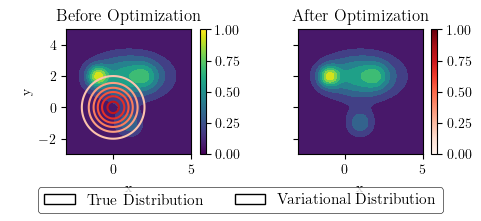

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
from scipy.optimize import minimize
from matplotlib import rc
from matplotlib.patches import Rectangle

# Set up the grid
x, y = np.mgrid[-3:5:.01, -3:5:.01]
pos = np.dstack((x, y))

# Define the true distribution (mixture of Gaussians)
mu1 = np.array([1, 2])
sigma1 = np.array([[3, 0], [0, 1]])
mu2 = np.array([2, 2])
sigma2 = np.array([[0.3, 0], [0, 0.3]])
mu3 = np.array([-1, 2])
sigma3 = np.array([[0.2, 0], [0, 0.2]])
mu4 = np.array([1, -1])
sigma4 = np.array([[0.4, 0], [0, 0.4]])
true_dist = (
    0.75 * multivariate_normal(mu1, sigma1).pdf(pos) +
    0.05 * multivariate_normal(mu2, sigma2).pdf(pos) +
    0.1 * multivariate_normal(mu3, sigma3).pdf(pos) +
    0.1 * multivariate_normal(mu4, sigma4).pdf(pos)
)

# Define the initial variational distribution
var_mu = np.array([0, 0])
var_sigma = np.array([[1, 0], [0, 1]])
var_dist = multivariate_normal(var_mu, var_sigma).pdf(pos)

# Define the KL divergence objective function
def kl_divergence(params):
    mu = params[:2]
    sigma = np.array([[params[2], 0], [0, params[3]]])
    var_dist = multivariate_normal(mu, sigma).pdf(pos)
    kl_div = np.sum(var_dist * (np.log(var_dist) - np.log(true_dist))) * 0.01 * 0.01
    return kl_div

# Optimize the variational distribution
initial_params = np.array([0, 0, 1, 1])
result = minimize(kl_divergence, initial_params, method='BFGS')
optimized_mu = result.x[:2]
optimized_sigma = np.array([[result.x[2], 0], [0, result.x[3]]])
optimized_var_dist = multivariate_normal(optimized_mu, optimized_sigma).pdf(pos)

# Set font to Computer Modern
rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)

# Create the subplots
fig, axs = plt.subplots(1, 2, figsize=(5.7, 2.15))

# Plot the true distribution
axs[0].contourf(x, y, true_dist, cmap='viridis')
axs[1].contourf(x, y, true_dist, cmap='viridis')

# Plot the initial and optimized variational distributions
levels = np.linspace(-0.03, 0.2, 10)  # Adjusted levels for better visibility
axs[0].contour(x, y, var_dist, cmap='Reds', levels=levels)
axs[1].contour(x, y, optimized_var_dist, cmap='Reds', levels=levels)

# Set labels and titles
axs[0].set_title('Before Optimization')
axs[1].set_title('After Optimization')
axs[0].set_xlabel('x')
axs[0].set_ylabel('y')
axs[1].set_xlabel('x')
axs[1].tick_params(labelleft=False)
for ax in axs:
    ax.set_aspect('equal')
    ax.set_xlim(-3, 5)
    ax.set_ylim(-3, 5)

# Create legend
legend_elements = [Rectangle((0, 0), 1, 1, facecolor='w', edgecolor='black', label='True Distribution'),
                   Rectangle((0, 0), 1, 1, facecolor='w', edgecolor='black', label='Variational Distribution')]

# Create colorbars for the legend
cmap_true = plt.cm.viridis
cmap_var = plt.cm.Reds
sm_true = plt.cm.ScalarMappable(cmap=cmap_true)
sm_var = plt.cm.ScalarMappable(cmap=cmap_var)
sm_true.set_array([])
sm_var.set_array([])

# Add colorbars to the legend
legend = fig.legend(handles=legend_elements, ncol=2, loc='lower center', fontsize=11)
legend.get_frame().set_linewidth(0.5)
legend.get_frame().set_edgecolor('black')

cbar_true = fig.colorbar(sm_true, ax=axs[0], fraction=0.046, pad=0.04)
cbar_var = fig.colorbar(sm_var, ax=axs[1], fraction=0.046, pad=0.04)

# Adjust layout and save the figure
plt.subplots_adjust(wspace=0.1, bottom=0.3)  # Adjust the spacing and positioning here
plt.savefig('./plots/variational_inference_schematic.pdf', dpi=300, bbox_extra_artists=(legend,), bbox_inches='tight')
plt.show()

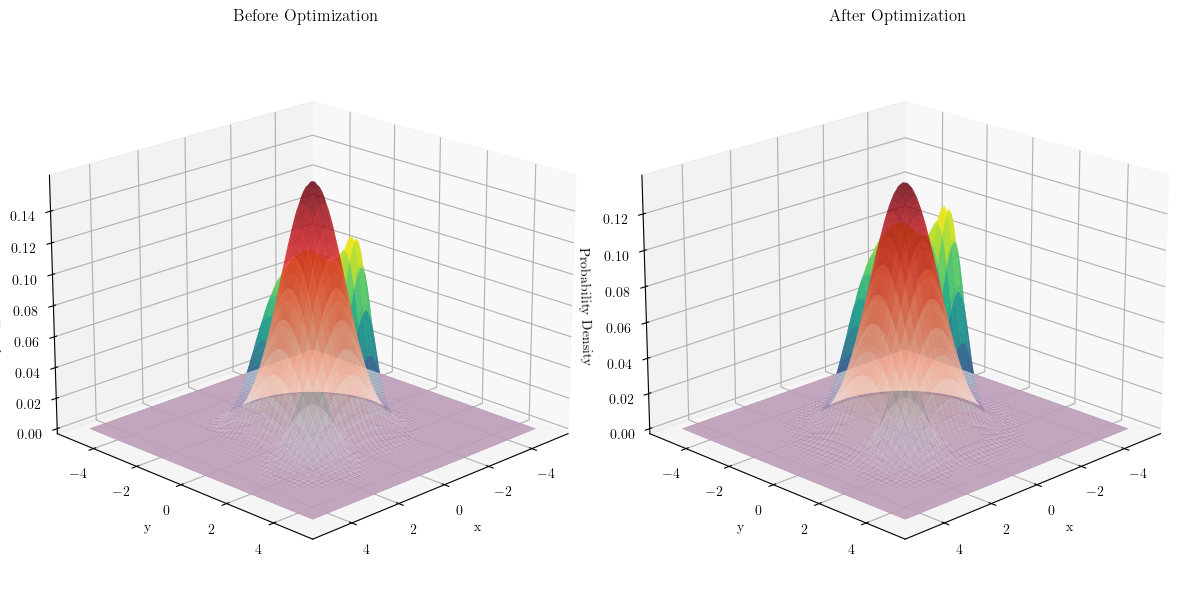

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
from scipy.optimize import minimize
from mpl_toolkits.mplot3d import Axes3D

# Set up the grid
x, y = np.mgrid[-5:5:.1, -5:5:.1]
pos = np.dstack((x, y))

# Define the true distribution (mixture of Gaussians)
mu1 = np.array([0, 0])
sigma1 = np.array([[1, 0], [0, 1]])
mu2 = np.array([2, 2])
sigma2 = np.array([[0.3, 0], [0, 0.3]])
mu3 = np.array([-1, 1])
sigma3 = np.array([[0.2, 0], [0, 0.2]])
mu4 = np.array([1, -1])
sigma4 = np.array([[0.4, 0], [0, 0.4]])
true_dist = (
    0.7 * multivariate_normal(mu1, sigma1).pdf(pos) +
    0.1 * multivariate_normal(mu2, sigma2).pdf(pos) +
    0.1 * multivariate_normal(mu3, sigma3).pdf(pos) +
    0.1 * multivariate_normal(mu4, sigma4).pdf(pos)
)

# Define the initial variational distribution
var_mu = np.array([0, 0])
var_sigma = np.array([[1, 0], [0, 1]])
var_dist = multivariate_normal(var_mu, var_sigma).pdf(pos)

# Define the KL divergence objective function
def kl_divergence(params):
    mu = params[:2]
    sigma = np.array([[params[2], 0], [0, params[3]]])
    var_dist = multivariate_normal(mu, sigma).pdf(pos)
    kl_div = np.sum(var_dist * (np.log(var_dist) - np.log(true_dist))) * 0.1 * 0.1
    return kl_div

# Optimize the variational distribution
initial_params = np.array([0, 0, 1, 1])
result = minimize(kl_divergence, initial_params, method='BFGS')
optimized_mu = result.x[:2]
optimized_sigma = np.array([[result.x[2], 0], [0, result.x[3]]])
optimized_var_dist = multivariate_normal(optimized_mu, optimized_sigma).pdf(pos)

# Create the 3D plot
fig = plt.figure(figsize=(12, 6))
ax1 = fig.add_subplot(121, projection='3d')
ax2 = fig.add_subplot(122, projection='3d')

# Plot the true distribution
ax1.plot_surface(x, y, true_dist, cmap='viridis', alpha=0.8)
ax2.plot_surface(x, y, true_dist, cmap='viridis', alpha=0.8)

# Plot the initial and optimized variational distributions
ax1.plot_surface(x, y, var_dist, cmap='Reds', alpha=0.6)
ax2.plot_surface(x, y, optimized_var_dist, cmap='Reds', alpha=0.6)

# Set labels and titles
ax1.set_title('Before Optimization')
ax2.set_title('After Optimization')
for ax in [ax1, ax2]:
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('Probability Density')
    ax.view_init(elev=20, azim=45)

plt.tight_layout()
plt.show()